# AI-LAB SESSION 4: Model-Based Reinforcement Learning

In this tutorial we will see some additional functionalities available to OpenAI Gym environments

## Cliff environment

The environment used is **Cliff** (taken from the book of Sutton and Barto as visible in the figure)
![CliffWalking](images/cliff.png)

The agent starts in cell $(3, 0)$ and has to reach the goal in $(3, 11)$. Falling from the cliff resets the position to the start state (the episode ends only when the goal state is reached). All other cells are safe. Action dinamycs is deterministic, meaning that the agent always reaches the desired next state.

## Assignment 1

Your first assignment is to implement the *Model-Based* algorithm on **Cliff**. In particular, you have first to learn the model by making the agent move in the environment and then solve it via *Value Iteration*. The solution returned must be a tuple *(policy, rewards, lengths)* where:
* *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
* *rewards*: array of rewards where the $i$-th reward refers to the $i$-th episode of the training performed
* *lengths*: array of lengths where the $i$-th length refers to the $i$-th episode of the training performed (length in number of steps)

Functions to implement:
* *model_based(environment, episodes, ep_limit, vmaxiters, gamma, delta)*

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
import envs
import numpy as np
from utils.funcs import run_episode, plot, rolling
from timeit import default_timer as timer

In the next cell you can copy the code for *Value Iteration* that you implemented in session 3

In [2]:
def value_iteration(environment, maxiters, gamma, delta):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: max iterations allowed
        gamma: gamma value
        delta: delta value
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    q = np.zeros(environment.observation_space.n, dtype="int8")  # Initial policy
    v = np.zeros(environment.observation_space.n)  #len(S)
    v_iter = 0

    while True:
        v_iter = v_iter + 1
        Vp = v.copy()

        q = (environment.T * (environment.R + gamma * Vp)).sum(axis=2)
        v = np.max(q, axis=1)

        if np.max((abs(v - Vp))) < delta or v_iter == maxiters:
            p = np.argmax(q, axis=1)
            return np.asarray(p)
    

The following function has to be implemented

In [3]:
def model_based(environment, episodes, ep_limit, vmaxiters, gamma, delta):
    """
    Performs the model-based algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        episodes: number of episodes for training
        ep_limit: limit to episode length
        vmaxiters: max iterations allowed for VI
        gamma: gamma value
        delta: delta value
        
    Returns:
        (policy, rewards, lengths): final policy, rewards for each episode [array], length of each episode [array]
    """
    rewards = np.zeros(episodes)  # Rewards array
    lengths = np.zeros(episodes)  # Lengths array
    policy = np.random.choice(environment.action_space.n, environment.observation_space.n)  # Random initial policy
    
    N_STATI = environment.observation_space.n
    N_AZIONI = environment.action_space.n
    
    T = np.zeros((N_STATI,N_AZIONI,N_STATI))
    R = np.zeros((N_STATI,N_AZIONI,N_STATI))
    
    for e in range(episodes):
        
        s = environment.reset()
        el = 0
        rew = 0
        lista_tuple = []
        
        for _ in range(ep_limit):
            
            sp, r, done, _ = environment.step(policy[s])  
            R[s, policy[s], sp] = r

            rew += r;
            el += 1;
            lista_tuple.append((s,policy[s],sp,r))
            
            if done or el == ep_limit:  
                break;
                
            s = sp #update dello stato
   

        countNT = np.zeros((N_STATI,N_AZIONI,N_STATI))
        countDT = np.zeros((N_STATI, N_AZIONI))

        #stimo il modello di transizione
        for tupla in lista_tuple:
            
            #leggo ogni tupla e procedo ai conteggi
            s = tupla[0]
            a = tupla[1]
            s1 = tupla[2]
            r = tupla[3]
            
            countNT[s, a, s1] = countNT[s, a, s1] + 1
            countDT[s, a] = countDT[s, a] + 1
           
            if(countDT[s, a] != 0):
                T[s, a, s1] = countNT[s, a, s1] / countDT[s, a];
                
        rewards[e] = rew
        lengths[e] = el
        environment.T = T
        environment.R = R
        policy = value_iteration(environment, vmaxiters, gamma, delta)
    
    
    return policy, rewards, lengths

The following code executes your implementation and prints the result

In [4]:
envname = "Cliff-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: ", envname)
print("----------------------------------------------------------------\n")

env = gym.make(envname)
env.render()
print()

# Learning parameters
episodes = 500
ep_limit = 50
vmaxiters = 50
gamma = .95
delta = 1e-3

t = timer()

# Model-Based
policy, rewards, lengths = model_based(env, episodes, ep_limit, vmaxiters, gamma, delta)
print("Execution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
    env.shape))))
_ = run_episode(env, policy, 20)


----------------------------------------------------------------
	Environment:  Cliff-v0
----------------------------------------------------------------

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


Execution time: 0.6372s
Policy:
[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U']]



Correct results for *Model-Based* reinforcement learning can be found [here](results/model_based_results.txt)

The next piece of code plots the performance of the agent during learning. Notice that a better performance is obtained with higher rewards and shorter episode lengths (the sooner the agent reaches the goal the better)

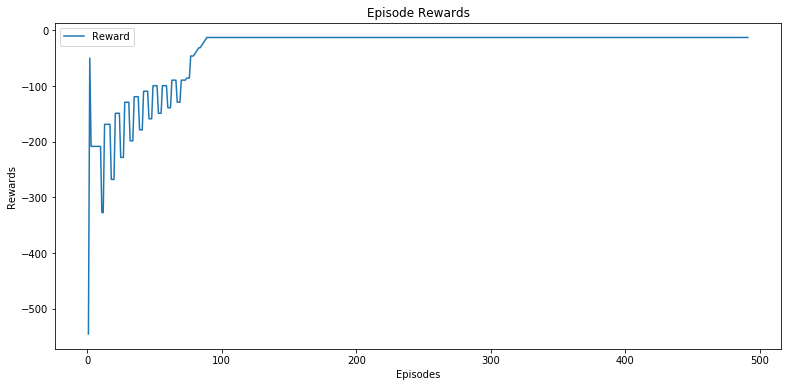

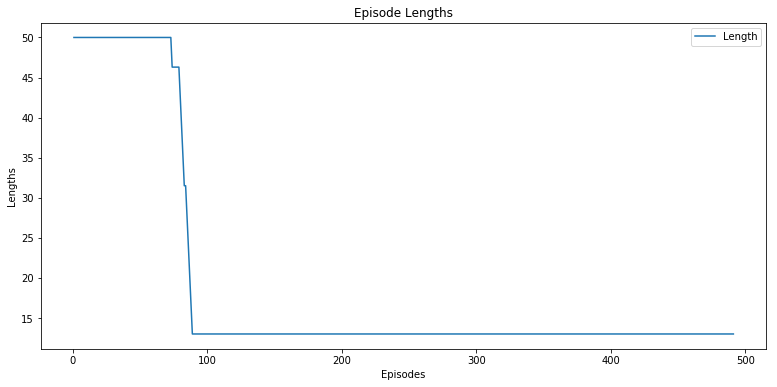

In [17]:
litres = np.arange(1, episodes + 1)  # Learning iteration values
window = 10  # Rolling window
rewards = rolling(rewards, window)
lengths = rolling(lengths, window)
plot([{"x": np.arange(1, len(rewards) + 1), "y": rewards, "label": "Reward"}], "Episode Rewards", "Episodes", "Rewards")
plot([{"x": np.arange(1, len(lengths) + 1), "y": lengths, "label": "Length"}], "Episode Lengths", "Episodes", "Lengths")

Correct results for the agent performance during learning can be found here below. Notice that since the charts could differ from yours: the important thing is the global trend.

### Rewards
![rewards](results/rewards.png)

### Lengths
![lengths](results/lengths.png)